---
# Filtering procedures for linescanning data

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:

import numpy as np
import pandas as pd
import nibabel as nb
from prfpy import *
from linescanning import *
from linescanning import glm,image,prf
import scipy as sp
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import os
import yaml

import nitime
from nitime.timeseries import TimeSeries
from nitime.analysis import SpectralAnalyzer, FilterAnalyzer, NormalizationAnalyzer

opj = os.path.join
base, place = utils.get_base_dir()

base_dir = opj(base, 'projects', 'hemifield')
fig_dir = opj(base_dir, 'code', 'figures', 'prf')

In [3]:
subject = 'sub-003'
ses = 'ses-3'
run = 3
plot_vox = 359

func_file = utils.get_file_from_substring(f"run-{run}_bold.mat", opj(base_dir, subject, ses, 'func'))
print(f"file = {func_file}")

func = utils.ParseFuncFile(func_file, subject=1, run=1, deleted_first_timepoints=100, deleted_last_timepoints=300)
fs = 1/func.TR
raw = func.get_raw(index=True)
psc = func.get_psc(index=True)
raw.head()

file = /data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-LR_run-3_bold.mat


vox 0     vox 1     vox 2     vox 3     vox 4     vox 5  \
subject run t                                                                   
1       1   0.000  0.073717  0.270543  0.245067  0.258288  0.108680  0.146122   
            0.105  0.034633  0.234440  0.149764  0.175327  0.024322  0.071265   
            0.210  0.121146  0.172399  0.141865  0.212087  0.236562  0.207676   
            0.315  0.164312  0.161958  0.150253  0.370128  0.187023  0.304310   
            0.420  0.245573  0.096567  0.109389  0.484871  0.065672  0.317091   

                      vox 6     vox 7     vox 8     vox 9  ...   vox 710  \
subject run t                                              ...             
1       1   0.000  0.270759  0.190942  0.315587  0.052950  ...  0.059258   
            0.105  0.550924  0.056280  0.422594  0.260957  ...  0.098735   
            0.210  0.373578  0.513698  0.333000  0.159817  ...  0.158242   
            0.315  0.570950  0.058211  0.309000  0.135681  ...  0.236857   
            0.420  0.331906  0.186227  0.169231  0.212452  ...  0.111611   

                    vox 711   vox 712   vox 713   vox 714   vox 715   vox 716  \
subject run t                                                                   
1       1   0.000  0.111118  0.194550  0.103874  0.171096  0.279826  0.226689   
            0.105  0.194400  0.119988  0.352145  0.106381  0.297444  0.224112   
            0.210  0.270215  0.332574  0.159053  0.387731  0.205112  0.205607   
            0.315  0.154144  0.079161  0.187930  0.223000  0.453817  0.220993   
            0.420  0.112545  0.341031  0.272752  0.394670  0.215269  0.511574   

                    vox 717   vox 718   vox 719  
subject run t                                    
1       1   0.000  0.140728  0.136082  0.204667  
            0.105  0.276106  0.190961  0.417584  
            0.210  0.277714  0.186546  0.172975  
            0.315  0.257707  0.176241  0.143434  
            0.420  0.283215  0.117771  0.033797  

[5 rows x 720 columns]

In [4]:
def percent_change(ts, ax):
    return (ts / np.expand_dims(np.mean(ts, ax), ax) - 1) * 100

---
# Inspect frequencies in the data

The distribution of power in a signal, as a function of frequency, known as the power spectrum (or PSD, for power spectral density) can be estimated using variants of the discrete Fourier transform (DFT). The naive estimate of the power spectrum, based on the values of the DFT estimated directly from the signal, using the fast Fourier transform algorithm (FFT) is referred to as a periodogram

In [5]:
# Calculate frequency-spectrum with various methods
psd = func.get_freq(datatype='raw', spectrum_type='psd')
fft = func.get_freq(datatype='raw', spectrum_type='fft')
per = func.get_freq(datatype='raw', spectrum_type='periodogram')
mta = func.get_freq(datatype='raw', spectrum_type='mtaper')

/home/heij/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


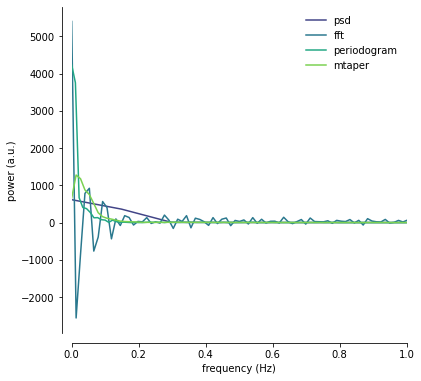

In [6]:
# plot frequency spectra
colors = sns.color_palette('viridis', 4)

fig,axs = plt.subplots(figsize=(6,6))

axs.plot(psd[0], psd[1][359], label='psd', color=colors[0])
axs.plot(fft[0], fft[1][359], label='fft', color=colors[1])
axs.plot(per[0], per[1][359], label='periodogram', color=colors[2])
axs.plot(mta[0], mta[1][359], label='mtaper', color=colors[3])
axs.set_xlim((0,1))
axs.set_xlabel('frequency (Hz)')
axs.set_ylabel('power (a.u.)')
axs.legend(frameon=False)
sns.despine(offset=10)

Notice that, for this data, simply extracting a FFT is hardly informative (the reasons for that are explained in Multitaper spectral estimation). On the other hand, the other methods provide different granularity of information, traded-off with the robustness of the estimation. The cadillac of spectral estimates is the multi-taper estimation, which provides both robustness and granularity, but notice that this estimate requires more computation than other estimates (certainly more estimates than the FFT) (http://nipy.org/nitime/examples/filtering_fmri.html) 

---
# Filtering procedures

We note that a lot of the power in the fMRI data seems to be concentrated in frequencies below 0.02 Hz. These extremely low fluctuations in signal are often considered to be ‘noise’, rather than reflecting neural processing. In addition, there is a broad distribution of power up to the Nyquist frequency. However, some estimates of the hemodynamic response suggest that information above 0.15 could not reflect the slow filtering of neural response to the BOLD response measured in fMRI. Thus, it would be advantageous to remove fluctuations below 0.02 and above 0.15 Hz from the data. Next, we proceed to filter the data into this range, using different methods.

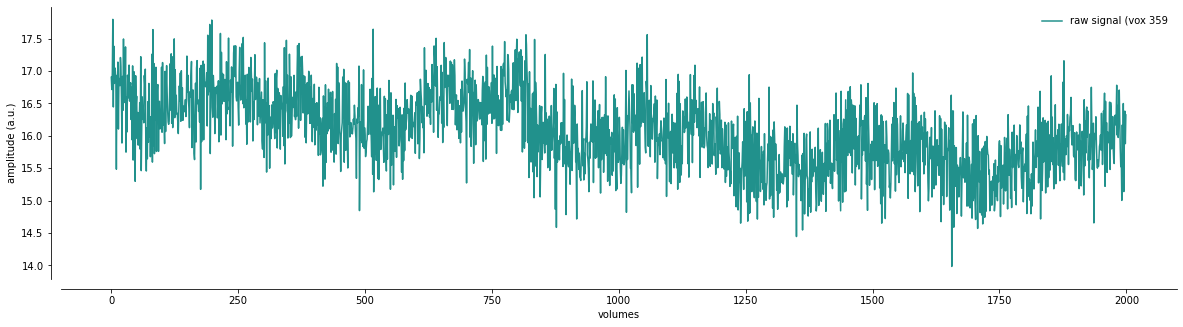

In [7]:
fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 1)
# axs.plot(rolling_median5[f'vox {plot_vox}'].values, color=colors[0], label=f"not detrended")
axs.plot(raw[f'vox {plot_vox}'].values, color=colors[0], label=f"raw signal (vox {plot_vox}")

axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (a.u.)')
axs.legend(frameon=False)
sns.despine(offset=10)

Transposed 'raw'-data has shape (720, 2000)


/home/heij/.local/lib/python3.6/site-packages/scipy/signal/filter_design.py:4071: RuntimeWarning: divide by zero encountered in true_divide
  (stopb * (passb[0] - passb[1])))


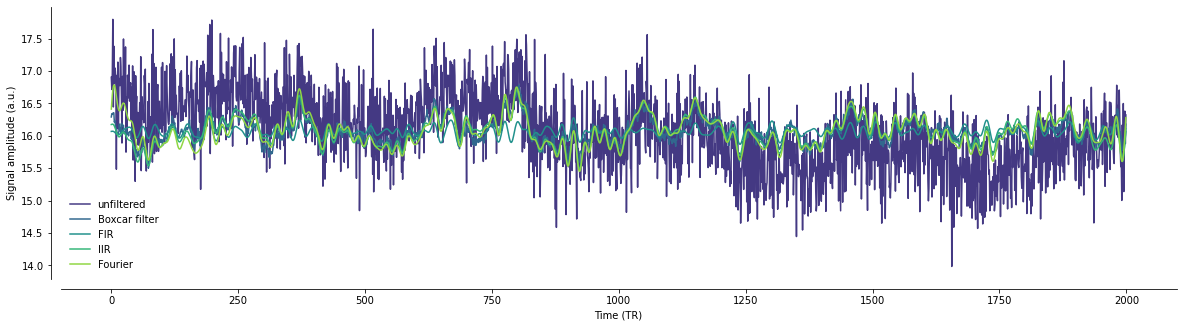

In [9]:
# initialize timeseries object
TC = TimeSeries(np.asarray(raw).T, sampling_interval=func.TR)
print(f"Transposed 'raw'-data has shape {TC.shape}")

# initialize filtering
FC = FilterAnalyzer(TC, ub=0.5, lb=0.02)

# Initialize a figure to display the results:
fig, axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 5)

# Plot the original, unfiltered data:
axs.plot(FC.data[plot_vox], label='unfiltered', color=colors[0])

# Boxcar filter: 
# The time-series is convolved with a box-car function of the right length to smooth the data to such an extent that the frequencies higher than represented by the 
# length of this box-car function are no longer present in the smoothed version of the time-series. This functions as a low-pass filter. The data can then be high-
# pass filtered by subtracting this version of the data from the original. For a band-pass filter, both of these operations are done.
axs.plot(FC.filtered_boxcar.data[plot_vox], label='Boxcar filter', color=colors[1])

# FIR filter: 
# A digital filter with a finite impulse response. These filters have an order of 64 per default, but that can be adjusted by setting the key word argument 
# ‘filt_order’, passed to initialize the FilterAnalyzer. For FIR filtering, nitime uses a Hamming window filter, but this can also be changed by setting the key word 
# nt ‘fir_win’. As with the boxcar filter, if band-pass filtering is required, a low-pass filter is applied and then a high-pass filter is applied to the resulting 
# time-series.
axs.plot(FC.fir.data[plot_vox], label='FIR', color=colors[2])

# IIR filter:
# A digital filter with an infinite impulse response function. Per default an elliptic filter is used here, but this can be changed, by setting the ‘iir_type’ 
# key word argument used when initializing the FilterAnalyzer.
# For both FIR filters and IIR filters, scipy.signal.filtfilt() is used in order to achieve zero phase delay filtering.
axs.plot(FC.iir.data[plot_vox], label='IIR', color=colors[3])

# Fourier filter: 
# This is a quick and dirty filter. The data is FFT-ed into the frequency domain. The power in the unwanted frequency bins is removed (by replacing the power in these 
# bins with zero) and the data is IFFT-ed back into the time-domain.
axs.plot(FC.filtered_fourier.data[plot_vox], label='Fourier', color=colors[4])

axs.legend(frameon=False)
axs.set_xlabel('Time (TR)')
axs.set_ylabel('Signal amplitude (a.u.)')
sns.despine(offset=10)

plt.show()

## Operational specs of functions inside SpectralAnalyzer
### Unfiltered: 
Input timeseries = output timeseries

### Box car:    
For each of the two bounds, a low-passed version is created by convolving with a box-car and then the low-passed version for the upper bound is added to the low-passed version for the lower bound subtracted from the signal, resulting in a band-passed version
            
### Fourier
Filter the time-series by passing it to the Fourier domain and null out the frequency bands outside of the range [lb,ub]

### IIR
Filter the time-series using an IIR filter. Filtering is done back and forth (using scipy.signal.filtfilt) to achieve zero phase delay

### FIR
Filter the time-series using an FIR digital filter. Filtering is done back and forth (using scipy.signal.filtfilt) to achieve zero phase delay

### Notes (http://nipy.org/nitime/examples/filtering_fmri.html)
Examining the resulting time-series closely reveals that large fluctuations in very slow frequencies have been removed, but also small fluctuations in high frequencies have been attenuated through filtering.

Comparing the resulting spectra of these different filters shows the various trade-offs of each filtering method, including the fidelity with which the original spectrum is replicated within the pass-band and the amount of attenuation within the stop-bands.

We can do that by initializng a SpectralAnalyzer for each one of the filtered time-series resulting from the above operation and plotting their spectra. For ease of compariso, we only plot the spectra using the multi-taper spectral estimation. At the level of granularity provided by this method, the diferences between the methods are emphasized:

In [10]:
S_original = SpectralAnalyzer(TC)
S_fourier = SpectralAnalyzer(FC.filtered_fourier)
S_boxcar = SpectralAnalyzer(FC.filtered_boxcar)
S_fir = SpectralAnalyzer(FC.fir)
S_iir = SpectralAnalyzer(FC.iir)

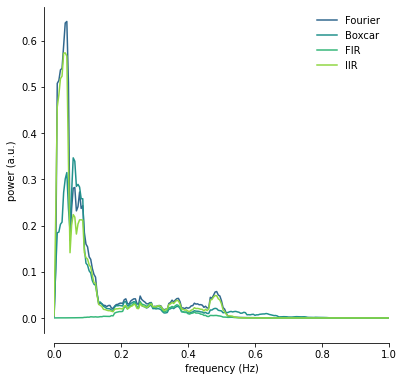

In [11]:
fig,axs = plt.subplots(figsize=(6,6))

# axs.plot(S_original.spectrum_multi_taper[0],
#         S_original.spectrum_multi_taper[1][plot_vox],
#         label='Original', color=colors[0])

axs.plot(S_fourier.spectrum_multi_taper[0],
          S_fourier.spectrum_multi_taper[1][plot_vox],
          label='Fourier', color=colors[1])

axs.plot(S_boxcar.spectrum_multi_taper[0],
          S_boxcar.spectrum_multi_taper[1][plot_vox],
          label='Boxcar', color=colors[2])

axs.plot(S_fir.spectrum_multi_taper[0],
          S_fir.spectrum_multi_taper[1][plot_vox],
          label='FIR', color=colors[3])

axs.plot(S_iir.spectrum_multi_taper[0],
          S_iir.spectrum_multi_taper[1][plot_vox],
          label='IIR', color=colors[4])

axs.set_xlim((0,1))
axs.set_xlabel('frequency (Hz)')
axs.set_ylabel('power (a.u.)')
axs.legend(frameon=False)
sns.despine(offset=10)

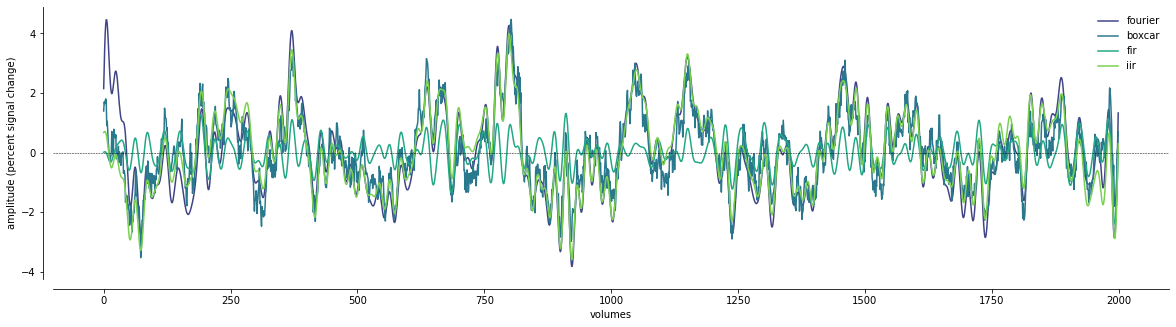

In [12]:
# percent signal change
# detrended_psc = (detrend_y / np.expand_dims(np.mean(detrend_y, -1), 0) - 1) * 100

fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 4)

# axs.plot(rolling_median5[f'vox {plot_vox}'].values, color=colors[0], label=f"not detrended")
axs.plot(NormalizationAnalyzer(FC.filtered_fourier).percent_change.data[plot_vox], color=colors[0], label='fourier')
axs.plot(NormalizationAnalyzer(FC.filtered_boxcar).percent_change.data[plot_vox], color=colors[1], label='boxcar')
axs.plot(NormalizationAnalyzer(FC.fir).percent_change.data[plot_vox], color=colors[2], label='fir')
axs.plot(NormalizationAnalyzer(FC.iir).percent_change.data[plot_vox], color=colors[3], label='iir')
axs.axhline(0, color='k', lw=0.5 , ls='--')

# axs.plot(detrend_psc, color=colors[1], label=f"detrended psc")
axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (percent signal change)')
axs.legend(frameon=False)
sns.despine(offset=10)

---
# Rolling median

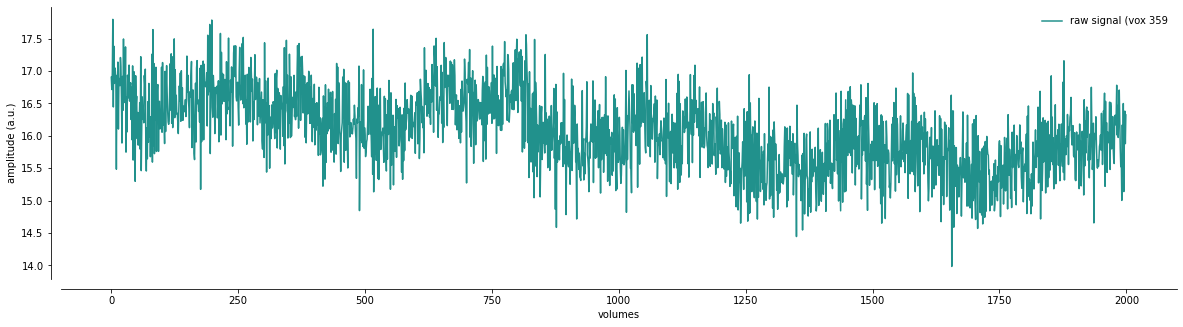

In [13]:
fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 1)
# axs.plot(rolling_median5[f'vox {plot_vox}'].values, color=colors[0], label=f"not detrended")
axs.plot(raw[f'vox {plot_vox}'].values, color=colors[0], label=f"raw signal (vox {plot_vox}")

axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (a.u.)')
axs.legend(frameon=False)
sns.despine(offset=10)

In [14]:
print(f"mean has shape {raw.values.mean(0)[np.newaxis, ...].shape}")
print(f"data has shape {raw.values.shape}")
(raw.values-raw.values.mean(0)[np.newaxis,...]).shape

mean has shape (1, 720)
data has shape (2000, 720)


(2000, 720)

In [15]:
mean = raw.values.mean(0)[np.newaxis,...]
raw_percent_signal = 100*(raw.values-mean) / mean
raw_percent_signal.shape

(2000, 720)

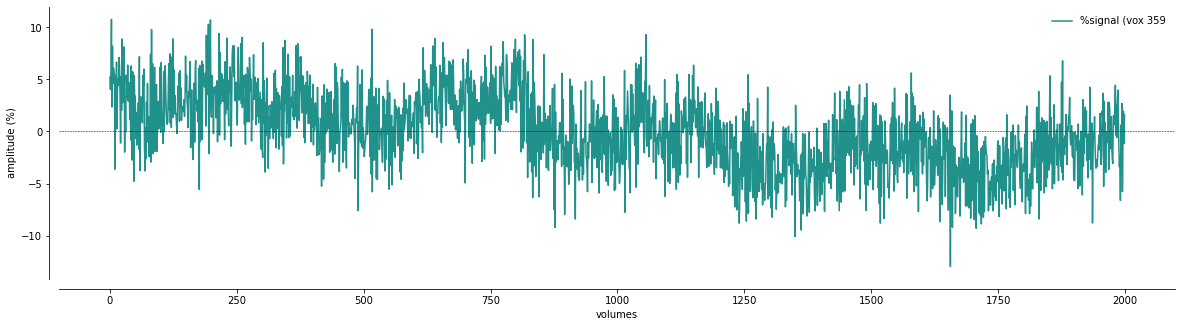

In [16]:
fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 1)
# axs.plot(rolling_median5[f'vox {plot_vox}'].values, color=colors[0], label=f"not detrended")
axs.plot(raw_percent_signal[:,plot_vox], color=colors[0], label=f"%signal (vox {plot_vox}")
axs.axhline(0, color='k', lw=0.5 , ls='--')

axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (%)')
axs.legend(frameon=False)
sns.despine(offset=10)

Detrended data has shape (2000, 720)


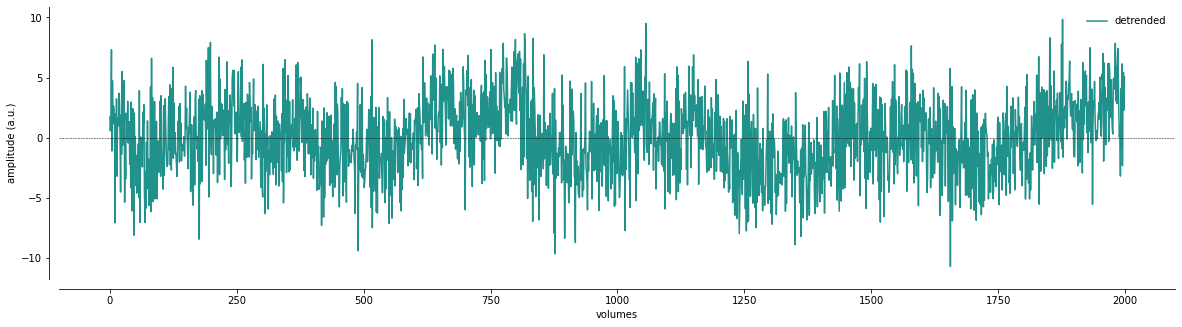

In [17]:
# signal detrending?
# https://stackoverflow.com/questions/44779315/detrending-data-with-nan-value-in-scipy-signal
from scipy import stats
from scipy.signal import detrend

y = raw_percent_signal #raw.values #[f'vox {plot_vox}'].values
# find linear regression line, subtract off data to detrend
detrend_raw = detrend(y, axis=0)

# detrend_y = detrend_y[...,np.newaxis]
print(f"Detrended data has shape {detrend_raw.shape}")

fig,axs = plt.subplots(figsize=(20,5))
axs.plot(detrend_raw[:,plot_vox], color=colors[0], label=f"detrended")
axs.set_xlabel('volumes')
axs.axhline(0, color='k', lw=0.5 , ls='--')

axs.set_ylabel('amplitude (a.u.)')
axs.legend(frameon=False)
sns.despine(offset=10)

In [18]:
detrend_df = pd.DataFrame(detrend_raw, index=raw.index, columns=raw.columns)
detrend_df.head()

vox 0      vox 1      vox 2       vox 3      vox 4  \
subject run t                                                               
1       1   0.000 -54.853600  29.804651  29.181614   10.426511 -47.214001   
            0.105 -73.078514  13.041576 -21.707237  -26.398756 -87.317802   
            0.210 -32.771645 -15.762333 -25.923683  -10.075001  13.576665   
            0.315 -12.665909 -20.613205 -21.442852   60.089417  -9.974605   
            0.420  25.193169 -50.972366 -43.261856  111.032463 -67.663895   

                       vox 5       vox 6       vox 7      vox 8      vox 9  \
subject run t                                                                
1       1   0.000 -22.227486    2.719967   -6.881564  44.058342 -56.157394   
            0.105 -64.667580  113.181076  -77.486862  92.582520  43.379047   
            0.210  12.685286   43.265083  162.375320  51.952648  -5.046558   
            0.315  67.484230  121.084328  -76.460388  41.068256 -16.616795   
            0.420  74.736023   26.843517   -9.326092 -22.314602  20.108389   

                   ...    vox 710    vox 711     vox 712    vox 713  \
subject run t      ...                                                
1       1   0.000  ... -68.002167 -28.161510   14.884105 -39.079651   
            0.105  ... -47.517883  23.744038  -28.809839  89.948387   
            0.210  ... -16.639593  70.995529   95.764130 -10.414885   
            0.315  ...  24.153687  -1.352119  -52.736183   4.586331   
            0.420  ... -40.839924 -27.282448  100.718216  48.664055   

                      vox 714     vox 715     vox 716    vox 717    vox 718  \
subject run t                                                                 
1       1   0.000   -2.719489   60.154202   24.778721 -38.457745 -31.642397   
            0.105  -38.148361   70.437576   23.492409  35.210583  -5.094882   
            0.210  115.860321   16.564312   14.333432  36.100239  -7.233402   
            0.315   25.682558  161.688980   21.925200  25.230331 -12.221285   
            0.420  119.651634   22.496916  165.535889  39.122959 -40.510929   

                      vox 719  
subject run t                  
1       1   0.000   11.931269  
            0.105  112.566109  
            0.210   -3.080476  
            0.315  -17.060501  
            0.420  -68.903412  

[5 rows x 720 columns]

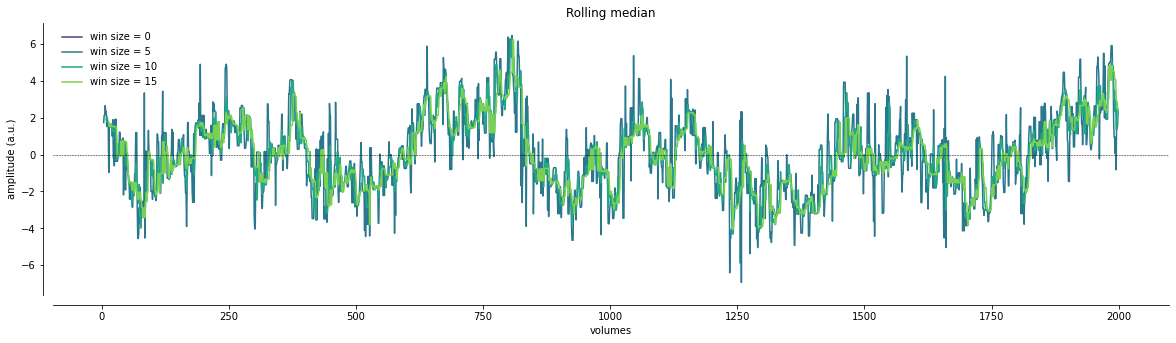

In [19]:
# Multiple rolling window sizes
win = [0,5,10,15]
fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', len(win))

for ix,ii in enumerate(win):
    rolling_median = detrend_df.rolling(ii, min_periods=None, center=False, win_type=None, on=None, axis=0, closed=None).median()
    axs.plot(rolling_median[f'vox {plot_vox}'].values, color=colors[ix], label=f"win size = {ii}")

axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (a.u.)')
axs.axhline(0, color='k', lw=0.5 , ls='--')

axs.set_title("Rolling median")
axs.legend(frameon=False)
sns.despine(offset=10)

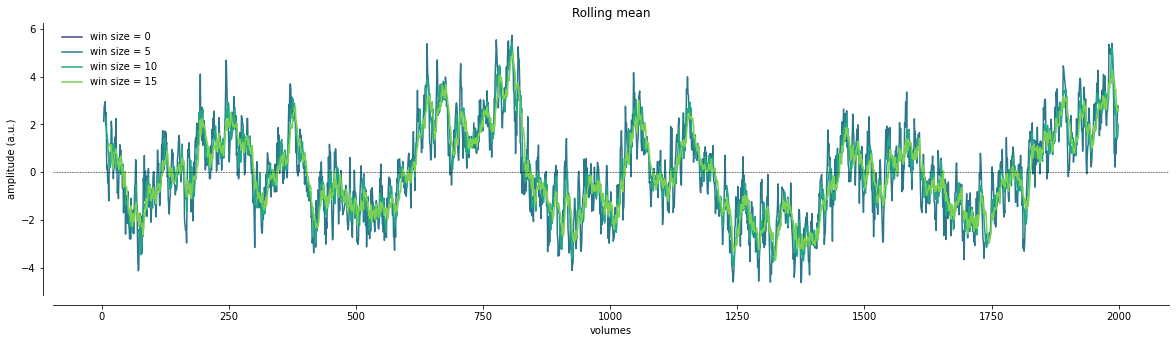

In [20]:
# ROLLING MEAN

# Multiple rolling window sizes
win = [0,5,10,15]
fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', len(win))
 
for ix,ii in enumerate(win):
    rolling_mean = detrend_df.rolling(ii, min_periods=None, center=False, win_type=None, on=None, axis=0, closed=None).mean()
    axs.plot(rolling_mean[f'vox {plot_vox}'].values, color=colors[ix], label=f"win size = {ii}")

axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (a.u.)')
axs.set_title("Rolling mean")
axs.axhline(0, color='k', lw=0.5 , ls='--')

axs.legend(frameon=False)
sns.despine(offset=10)

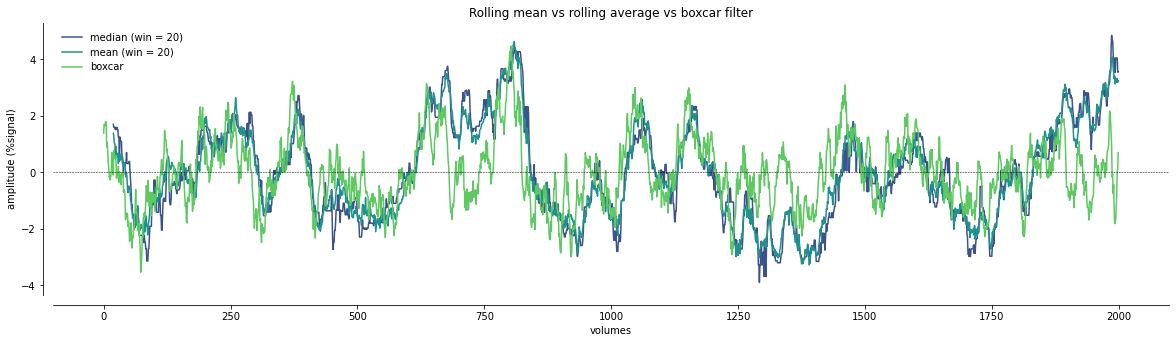

In [21]:
# ROLLING MEDIAN vs ROLLING MEAN vs BOXCAR-FILTERING

# Multiple rolling window sizes
fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 3)

win = 20
 
rolling_median5 = detrend_df.rolling(win, min_periods=None, center=False, win_type=None, on=None, axis=0, closed=None).median()
rolling_mean5 = detrend_df.rolling(win, min_periods=None, center=False, win_type=None, on=None, axis=0, closed=None).mean()

axs.plot(rolling_median5[f"vox {plot_vox}"].values, color=colors[0], label=f'median (win = {win})')
axs.plot(rolling_mean5[f"vox {plot_vox}"].values, color=colors[1], label=f'mean (win = {win})')
axs.plot(NormalizationAnalyzer(FC.filtered_boxcar).percent_change.data[plot_vox], color=colors[-1], label='boxcar')

axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (%signal)')
axs.set_title("Rolling mean vs rolling average vs boxcar filter")
axs.axhline(0, color='k', lw=0.5 , ls='--')

axs.legend(frameon=False)
sns.despine(offset=10)

---
# Highpass filtering > percent signal change > Detrend > rolling median

## Raw signal

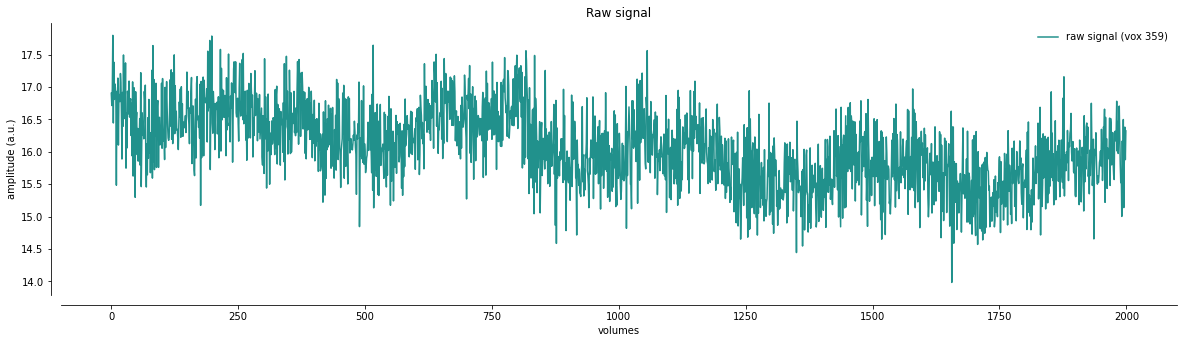

In [22]:
fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 1)
# axs.plot(rolling_median5[f'vox {plot_vox}'].values, color=colors[0], label=f"not detrended")
axs.plot(raw[f'vox {plot_vox}'].values, color=colors[0], label=f"raw signal (vox {plot_vox})")

axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (a.u.)')
axs.set_title("Raw signal")
axs.legend(frameon=False)
sns.despine(offset=10)

## Highpass filter

In [23]:
def _butter_highpass(data, lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='highpass')
    y = signal.filtfilt(b, a, data)
    return y

from scipy import signal
# set parameters
fs = 1/func.TR
order = 3
hp = 0.01

hp_raw = _butter_highpass(raw.values, hp, fs, order=3)
hp_raw.shape

(2000, 720)

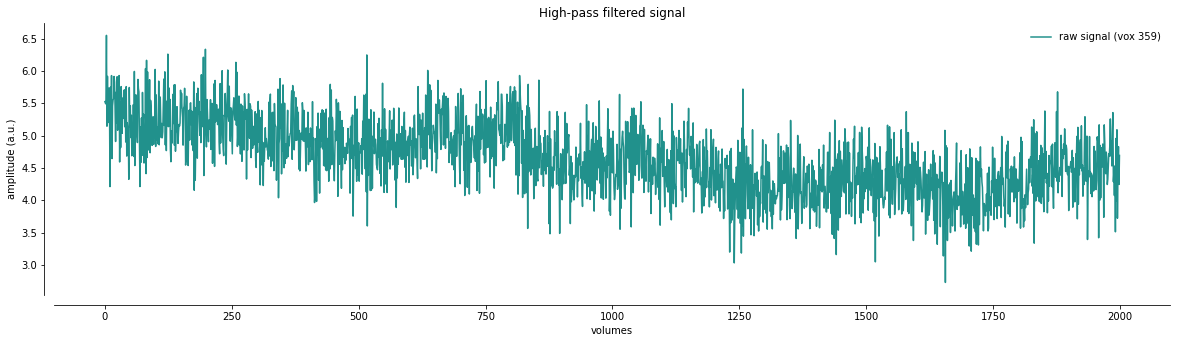

In [24]:
fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 1)
# axs.plot(rolling_median5[f'vox {plot_vox}'].values, color=colors[0], label=f"not detrended")
axs.plot(hp_raw[:,plot_vox], color=colors[0], label=f"raw signal (vox {plot_vox})")

axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (a.u.)')
axs.set_title("High-pass filtered signal")
axs.legend(frameon=False)
sns.despine(offset=10)

## Percent signal change

In [25]:
mean = hp_raw.mean(0)[np.newaxis,...]
hp_raw_psc1 = 100*(hp_raw-mean) / mean
print(f"psc method 1 shape = {hp_raw_psc1.shape}")

hp_raw_psc = percent_change(hp_raw,0)
print(f"psc method 2 shape = {hp_raw_psc.shape}")

print(hp_raw_psc1[:,plot_vox])
print(hp_raw_psc[:,plot_vox])

psc method 1 shape = (2000, 720)
psc method 2 shape = (2000, 720)
[18.69  18.16  17.929 ...  3.736 -8.827  0.793]
[18.69  18.16  17.929 ...  3.736 -8.827  0.793]


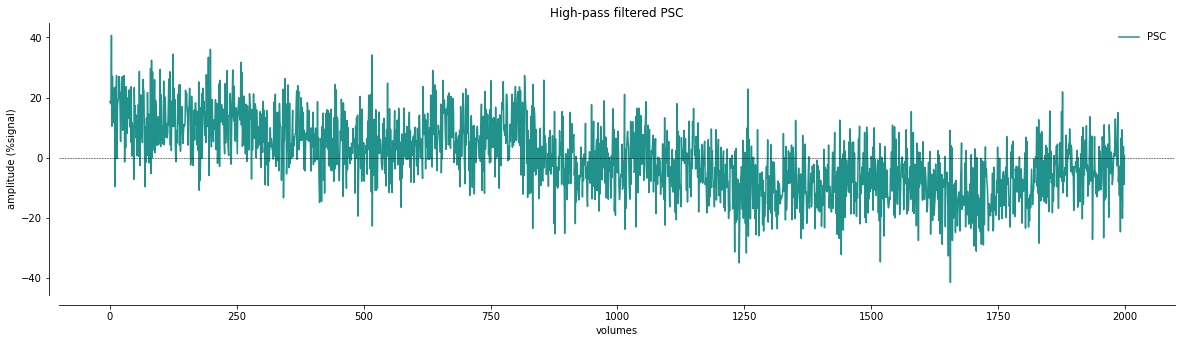

In [26]:
fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 1)
# axs.plot(rolling_median5[f'vox {plot_vox}'].values, color=colors[0], label=f"not detrended")
axs.plot(hp_raw_psc[:,plot_vox], color=colors[0], label=f"PSC")

axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (%signal)')
axs.set_title("High-pass filtered PSC")
axs.axhline(0, color='k', lw=0.5 , ls='--')

axs.legend(frameon=False)
sns.despine(offset=10)

## Detrend

Detrended data has shape (2000, 720)


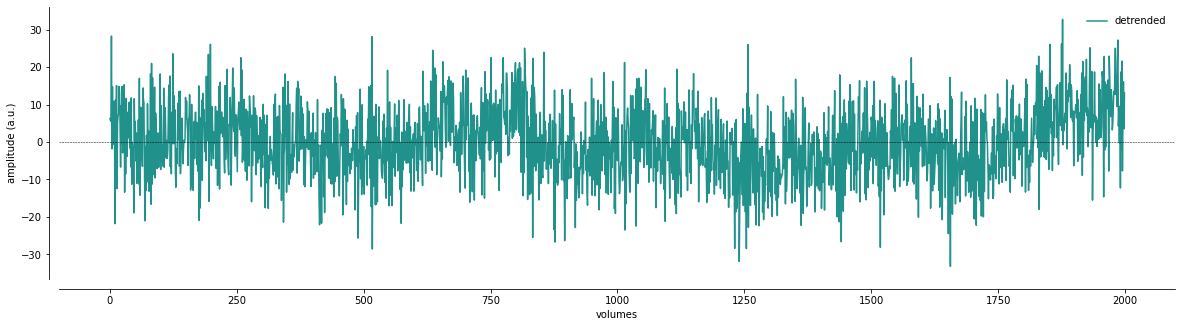

In [27]:
detrend_psc = sp.signal.detrend(hp_raw_psc, axis=0)

# detrend_y = detrend_y[...,np.newaxis]
print(f"Detrended data has shape {detrend_psc.shape}")

fig,axs = plt.subplots(figsize=(20,5))
axs.plot(detrend_psc[:,plot_vox], color=colors[0], label=f"detrended")
axs.axhline(0, color='k', lw=0.5 , ls='--')
axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (a.u.)')
axs.legend(frameon=False)
sns.despine(offset=10)

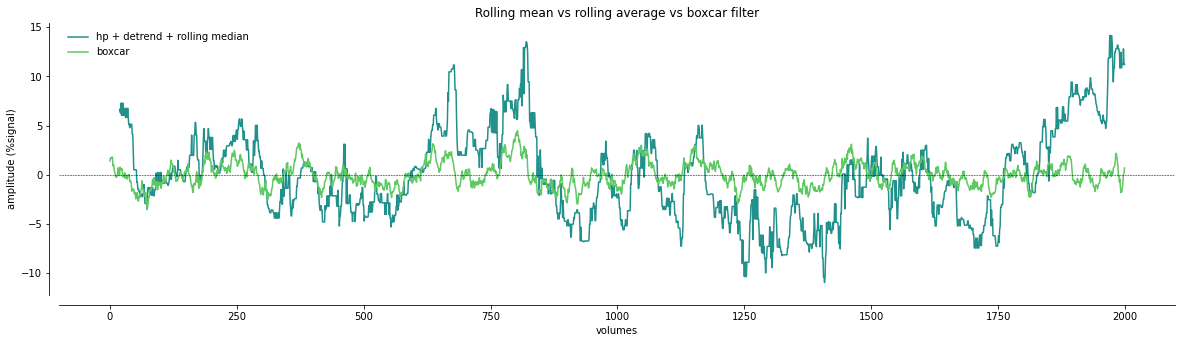

In [28]:
# ROLLING MEDIAN vs ROLLING MEAN vs BOXCAR-FILTERING

# Multiple rolling window sizes
fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 3)

win = 20

hp_det_psc_df = pd.DataFrame(detrend_psc, index=raw.index, columns=raw.columns)
hp_psc_df = pd.DataFrame(hp_raw_psc, index=raw.index, columns=raw.columns)

rm_det = hp_det_psc_df.rolling(win, min_periods=None, center=False, win_type=None, on=None, axis=0, closed=None).median()
rm = hp_psc_df.rolling(win, min_periods=None, center=False, win_type=None, on=None, axis=0, closed=None).median()

# axs.plot(rm[f"vox {plot_vox}"].values, color=colors[0], label='hp + rolling median')
axs.plot(rm_det[f"vox {plot_vox}"].values, color=colors[1], label='hp + detrend + rolling median')
axs.plot(NormalizationAnalyzer(FC.filtered_boxcar).percent_change.data[plot_vox], color=colors[-1], label='boxcar')

axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (%signal)')
axs.set_title("Rolling mean vs rolling average vs boxcar filter")
axs.axhline(0, color='k', lw=0.5 , ls='--')
axs.legend(frameon=False)
sns.despine(offset=10)

---
# The boxcar filter

In [29]:
from nitime.algorithms.filter import boxcar_filter
help(boxcar_filter)

Help on function boxcar_filter in module nitime.algorithms.filter:

boxcar_filter(time_series, lb=0, ub=0.5, n_iterations=2)
    Filters data into a frequency range.
    
    For each of the two bounds, a low-passed version is created by convolving
    with a box-car and then the low-passed version for the upper bound is added
    to the low-passed version for the lower bound subtracted from the signal,
    resulting in a band-passed version
    
    Parameters
    ----------
    
    time_series: float array
       the signal
    ub : float, optional
      The cut-off frequency for the low-pass filtering as a proportion of the
      sampling rate. Default to 0.5 (Nyquist)
    lb : float, optional
      The cut-off frequency for the high-pass filtering as a proportion of the
      sampling rate. Default to 0
    n_iterations: int, optional
      how many rounds of smoothing to do. Default to 2.
    
    Returns
    -------
    float array:
      The signal, filtered



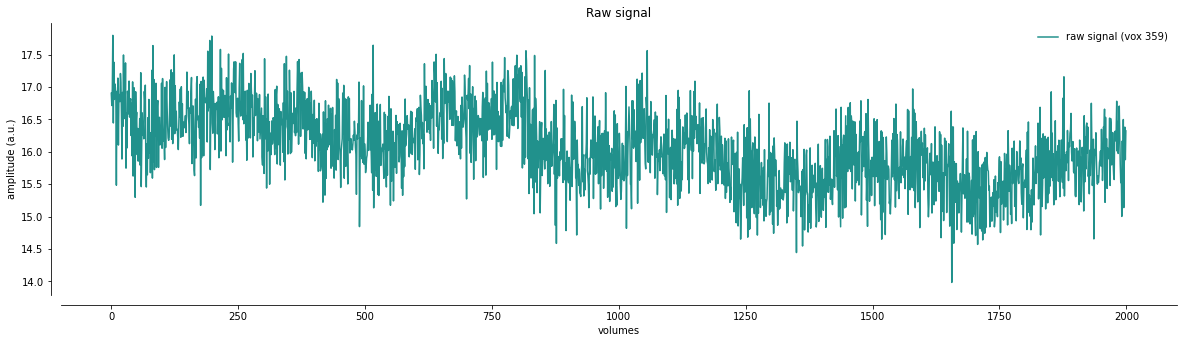

In [30]:
fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 1)
# axs.plot(rolling_median5[f'vox {plot_vox}'].values, color=colors[0], label=f"not detrended")
axs.plot(raw[f'vox {plot_vox}'].values, color=colors[0], label=f"raw signal (vox {plot_vox})")

axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (a.u.)')
axs.set_title("Raw signal")
axs.legend(frameon=False)
sns.despine(offset=10)

In [31]:
time_series = np.asarray(raw.copy()).T
lp_signal = time_series.copy()
hp_signal = time_series.copy()

print(f"Timeseries has shape {time_series.shape}")

lb = 0.02 / fs
ub = 0.15 / fs
print(f"fs = {fs}\nlb = {lb}\nub = {ub}")

n = time_series.shape[-1]
n_iterations = 1

len_boxcar_ub = np.ceil(1 / (2.0 * ub))
boxcar_ub = np.empty(int(len_boxcar_ub))
boxcar_ub.fill(1.0 / len_boxcar_ub)
boxcar_ones_ub = np.ones_like(boxcar_ub)

if lb == 0:
    lb = None
else:
    len_boxcar_lb = np.ceil(1 / (2.0 * lb))
    boxcar_lb = np.empty(int(len_boxcar_lb))
    boxcar_lb.fill(1.0 / len_boxcar_lb)
    boxcar_ones_lb = np.ones_like(boxcar_lb)

for i in range(time_series.shape[0]):
    if ub:
        # Start by applying a low-pass to the signal.  Pad the signal on
        # each side with the initial and terminal signal value:
        pad_s = np.hstack((boxcar_ones_ub *
                            time_series[i, 0], time_series[i]))
        pad_s = np.hstack((pad_s, boxcar_ones_ub * time_series[i, -1]))

        # Filter operation is a convolution with the box-car(iterate,
        # n_iterations times over this operation):
        for iteration in range(n_iterations):
            conv_s = np.convolve(pad_s, boxcar_ub)
            conv_ub = conv_s.copy()

        # Extract the low pass signal by excising the central
        # len(time_series) points:
        time_series[i] = conv_s[conv_s.shape[-1] // 2 -
                                int(np.floor(n / 2.)):
                                conv_s.shape[-1] // 2 +
                                int(np.ceil(n / 2.))]

        lp_signal[i] = time_series[i].copy()

    # Now, if there is a high-pass, do the same, but in the end subtract
    # out the low-passed signal:
    if lb:
        pad_s = np.hstack((boxcar_ones_lb *
                            time_series[i, 0], time_series[i]))
        pad_s = np.hstack((pad_s, boxcar_ones_lb * time_series[i, -1]))

        #Filter operation is a convolution with the box-car(iterate,
        #n_iterations times over this operation):
        for iteration in range(n_iterations):
            conv_s = np.convolve(pad_s, boxcar_lb)
            conv_lb = conv_s.copy()
        #Extract the low pass signal by excising the central
        #len(time_series) points:
        s_lp = conv_s[conv_s.shape[-1] // 2 - int(np.floor(n / 2.)):
                        conv_s.shape[-1] // 2 + int(np.ceil(n / 2.))]
        
        hp_signal[i] = time_series[i]
        #Extract the high pass signal simply by subtracting the high pass
        #signal from the original signal:
        time_series[i] = time_series[i] - s_lp + np.mean(s_lp)  # add mean
        #to make sure that there are no negative values. This also seems to
        #make sure that the mean of the signal (in % signal change) is
        #close to 0                                         

Timeseries has shape (720, 2000)
fs = 9.523809523809524
lb = 0.0021
ub = 0.01575


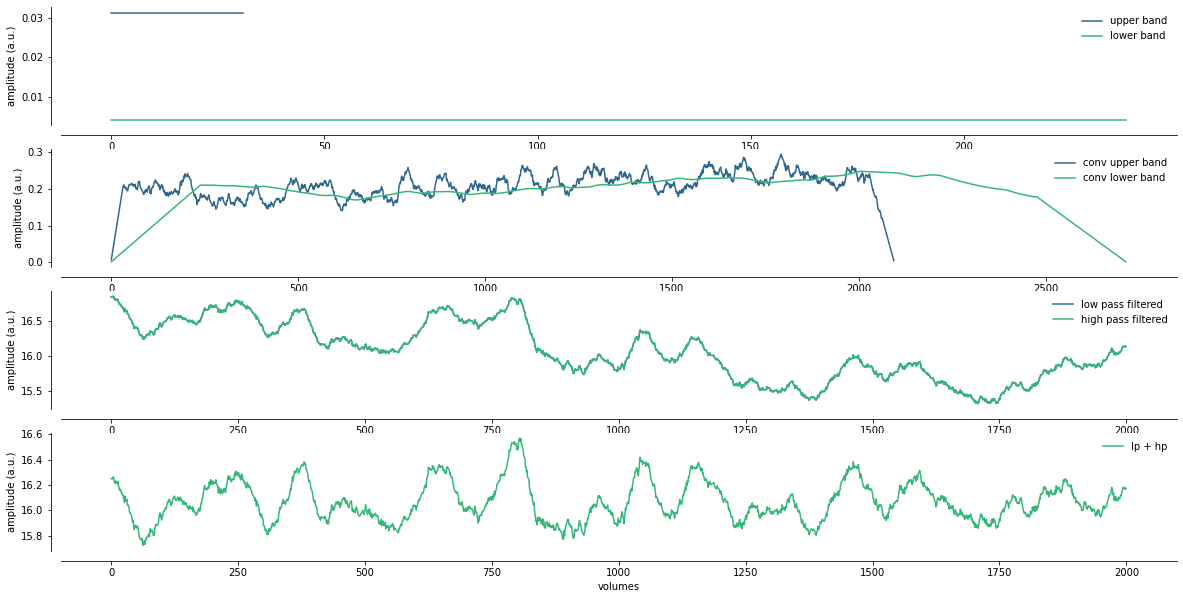

In [32]:
fig,axs = plt.subplots(4,1, figsize=(20,10))
colors = sns.color_palette('viridis', 2)

axs[0].plot(boxcar_ub, color=colors[0], label="upper band")
axs[0].plot(boxcar_lb, color=colors[1], label="lower band")
axs[0].set_xlabel('volumes')
axs[0].set_ylabel('amplitude (a.u.)')
axs[0].legend(frameon=False)

axs[1].plot(conv_ub, color=colors[0], label="conv upper band")
axs[1].plot(conv_lb, color=colors[1], label="conv lower band")
axs[1].set_xlabel('volumes')
axs[1].set_ylabel('amplitude (a.u.)')
axs[1].legend(frameon=False)

axs[2].plot(lp_signal[plot_vox,:], color=colors[0], label="low pass filtered")
axs[2].plot(hp_signal[plot_vox,:], color=colors[1], label="high pass filtered")
axs[2].set_xlabel('volumes')
axs[2].set_ylabel('amplitude (a.u.)')
axs[2].legend(frameon=False)

axs[-1].plot(time_series[plot_vox,:], color=colors[1], label="lp + hp")
axs[-1].set_xlabel('volumes')
axs[-1].set_ylabel('amplitude (a.u.)')
axs[-1].legend(frameon=False)
sns.despine(offset=10)

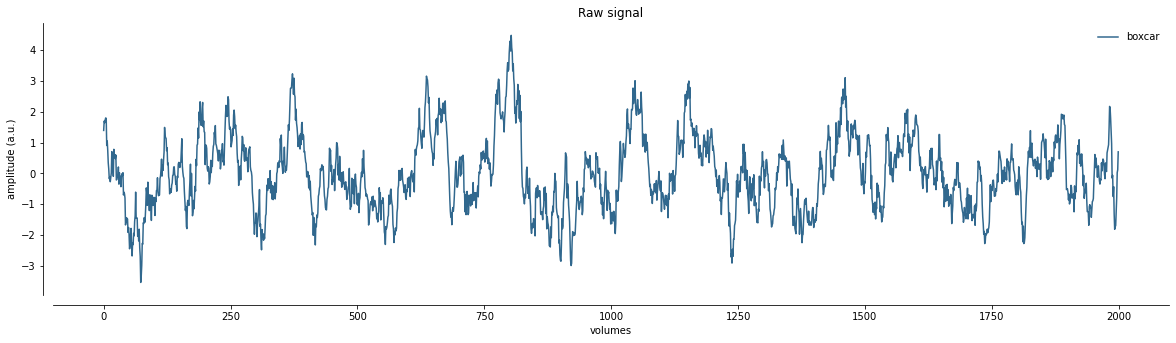

In [33]:
fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 2)
# axs.plot(rolling_median5[f'vox {plot_vox}'].values, color=colors[0], label=f"not detrended")
# axs.plot(raw[f'vox {plot_vox}'].values, color=colors[0], label=f"raw signal (vox {plot_vox})")
axs.plot(NormalizationAnalyzer(FC.filtered_boxcar).percent_change.data[plot_vox], color=colors[0], label='boxcar')
axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (a.u.)')
axs.set_title("Raw signal")
axs.legend(frameon=False)
sns.despine(offset=10)

---
# Hanning filtering

Another way to low-pass a signal is to use convolution. In this method you create a window (typically a bell-shaped curve) and convolve the window with the signal. The wider the window is the smoother the output signal will be. Also, the window must be normalized so its sum is 1 to preserve the amplitude of the input signal.

There are different ways to handle what happens to data points at the edges (see numpy.convolve for details), but setting mode to valid delete these points to produce an output signal slightly smaller than the input signal.

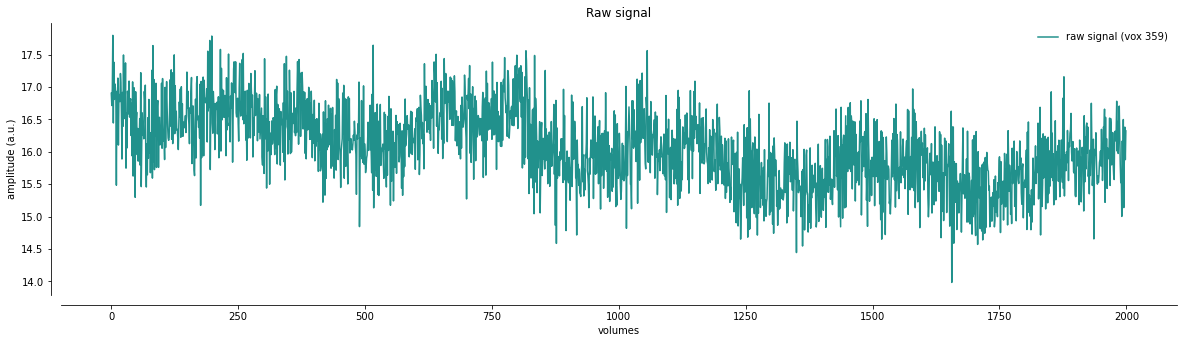

In [34]:
fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 1)
# axs.plot(rolling_median5[f'vox {plot_vox}'].values, color=colors[0], label=f"not detrended")

raw_data = raw[f'vox {plot_vox}'].values
axs.plot(raw_data, color=colors[0], label=f"raw signal (vox {plot_vox})")

axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (a.u.)')
axs.set_title("Raw signal")
axs.legend(frameon=False)
sns.despine(offset=10)

In [35]:
# import scipy.signal
# import numpy as np
# import matplotlib.pyplot as plt

# see: https://swharden.com/blog/2020-09-23-signal-filtering-in-python/

# times = np.arange(len(raw))/fs

print(f"Data has shape {raw_data.shape}")
# nyq = 0.5 * fs
# # apply a 3-pole lowpass filter at 0.1x Nyquist frequency
# b, a = scipy.signal.butter(3, 0.1)
# filtered = scipy.signal.filtfilt(b, a, np.asarray(raw))
# print(filtered.shape)

# create a normalized Hanning window
windowSize = 20
window = np.hanning(windowSize)
window = window / window.sum()

# filter the data using convolution
filtered = np.convolve(window, raw_data, mode='valid')
print(f"Filtered data has shape {filtered.shape}")

Data has shape (2000,)
Filtered data has shape (1981,)


The second argument passed into the butter method customizes the cut-off frequency of the Butterworth filter. This value (Wn) is a number between 0 and 1 representing the fraction of the Nyquist frequency to use for the filter. Note that Nyquist frequency is half of the sample rate. As this fraction increases, the cutoff frequency increases. You can get fancy and express this value as 2 * Hz / sample rate.

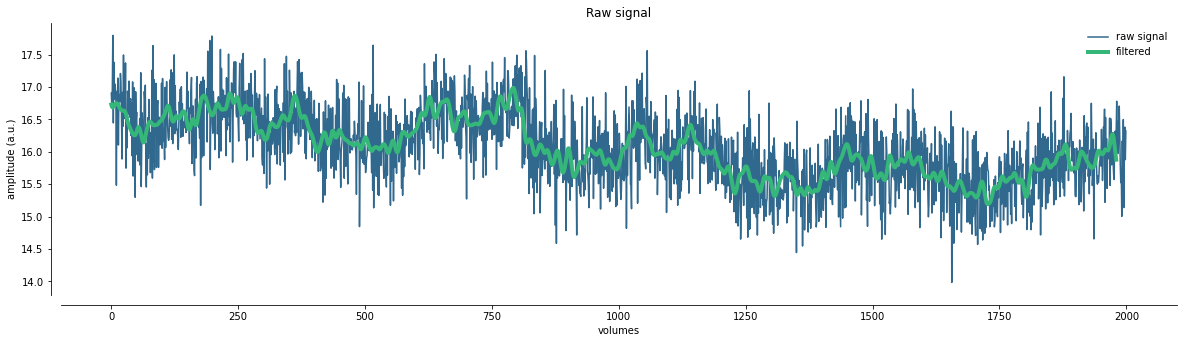

In [36]:
fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 2)
# axs.plot(rolling_median5[f'vox {plot_vox}'].values, color=colors[0], label=f"not detrended")

axs.plot(raw_data, color=colors[0], label=f"raw signal")
axs.plot(filtered, color=colors[1], label=f"filtered", lw=4)
axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (a.u.)')
axs.set_title("Raw signal")
axs.legend(frameon=False)
sns.despine(offset=10)

(1981,)


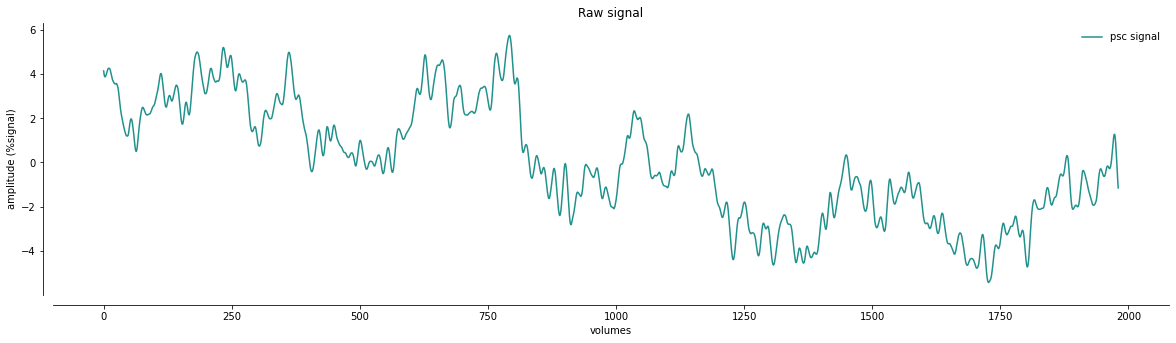

In [37]:
# convert to percent change
filtered_psc = percent_change(filtered, 0)
print(filtered_psc.shape)

fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 1)

axs.plot(filtered_psc, color=colors[0], label=f"psc signal")
axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (%signal)')
axs.set_title("Raw signal")
axs.legend(frameon=False)
sns.despine(offset=10)

Detrended data has shape (1981,)


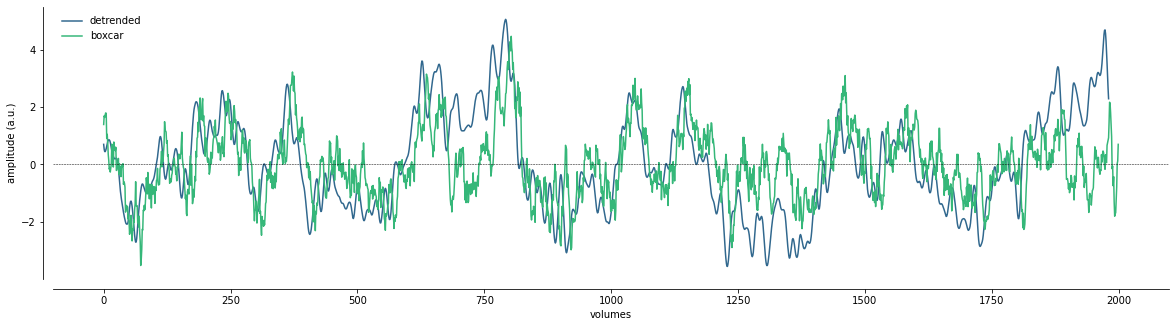

In [38]:
filtered_detrend = sp.signal.detrend(filtered_psc, axis=0)

# detrend_y = detrend_y[...,np.newaxis]
print(f"Detrended data has shape {filtered_detrend.shape}")

fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 2)

axs.plot(filtered_detrend, color=colors[0], label=f"detrended")
axs.plot(NormalizationAnalyzer(FC.filtered_boxcar).percent_change.data[plot_vox], color=colors[1], label='boxcar')

axs.axhline(0, color='k', lw=0.5 , ls='--')
axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (a.u.)')
axs.legend(frameon=False)
sns.despine(offset=10)

In [39]:
%reload_ext autoreload
%autoreload 2

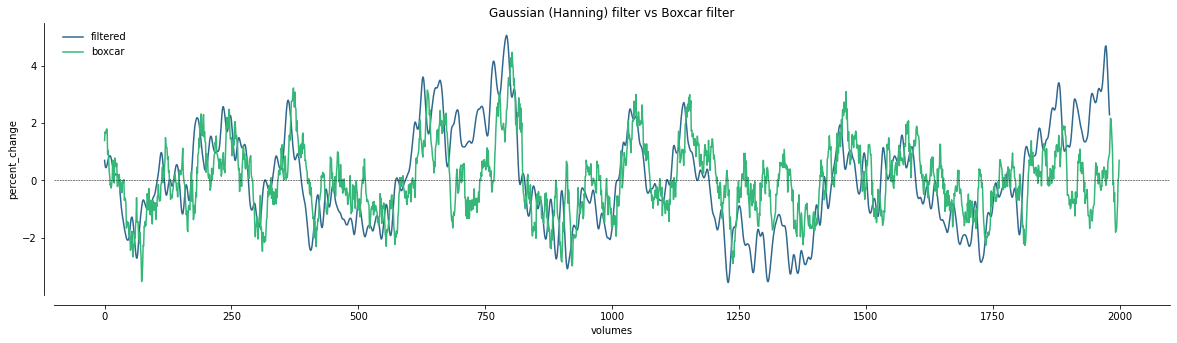

In [40]:
glm.plot_array([filtered_detrend, NormalizationAnalyzer(FC.filtered_boxcar).percent_change.data[plot_vox]], 
               figsize=(20,5), 
               x_label="volumes", 
               y_label="percent_change",
               title="Gaussian (Hanning) filter vs Boxcar filter",
               labels=["filtered", "boxcar"],
               add_hline={'pos': 0, 'color': 'k', 'lw': 0.5, 'ls': '--'})

---
# Try some functions within nilearn.signal and pybest

(2000, 720)


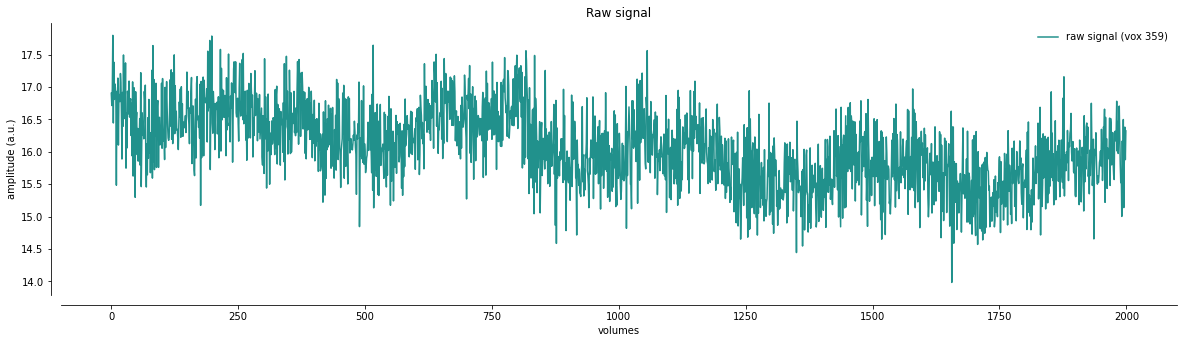

In [43]:
fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 1)
# axs.plot(rolling_median5[f'vox {plot_vox}'].values, color=colors[0], label=f"not detrended")

raw_data = raw[f'vox {plot_vox}'].values
axs.plot(raw_data, color=colors[0], label=f"raw signal (vox {plot_vox})")

axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (a.u.)')
axs.set_title("Raw signal")
axs.legend(frameon=False)
sns.despine(offset=10)

print(raw.shape)

In [51]:
# Create high-pass filter and clean
from scipy import signal
from nilearn.signal import clean
from nilearn.glm.first_level.design_matrix import _cosine_drift as dct_set

n_vol = raw.shape[0]
tr = func.TR
st_ref = 0  # offset frametimes by st_ref * tr
ft = np.linspace(st_ref * tr, (n_vol + st_ref) * tr, n_vol, endpoint=False)
ft.shape

hp_set = dct_set(0.01, ft)
filt_dct = clean(raw.values, detrend=False, standardize='psc', confounds=hp_set)



(2000,)

In [75]:
func.ts_corrected.T.shape

(2000, 720)

In [76]:
# filter with DCT or SG
## DCT
hp_set = dct_set(0.01, ft)
filt_dct = clean(raw.values, detrend=False, standardize='psc', confounds=hp_set)

## SAVGOL
window = int(np.round((1/0.01)/tr))

if (window % 2) == 0:
    window += 1
    
filt_sg = raw.values - signal.savgol_filter(raw.values, window_length=window, polyorder=2, axis=0)

print(f"DCT: {filt_dct.shape}")
print(f"SAV: {filt_sg.shape}")

DCT: (2000, 720)
SAV: (2000, 720)


(2000, 720)


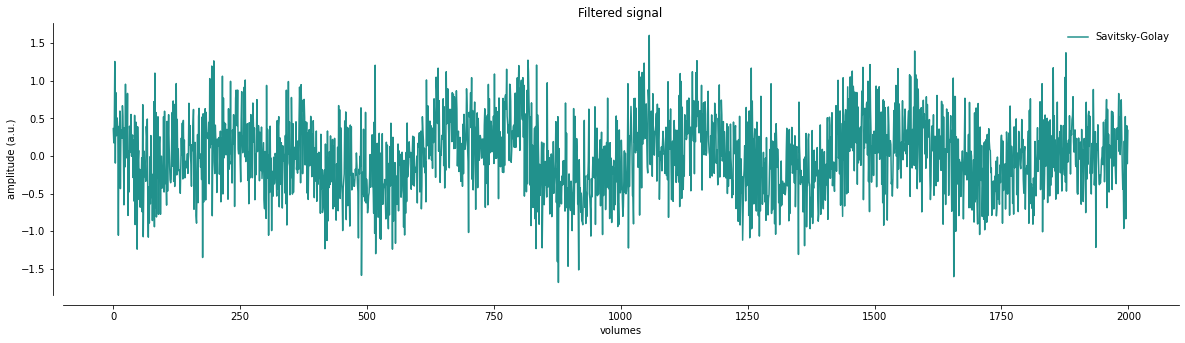

In [77]:
fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 1)
# axs.plot(rolling_median5[f'vox {plot_vox}'].values, color=colors[0], label=f"not detrended")

# axs.plot(filt_dct[:,plot_vox], color=colors[0], label=f"DCT filt")
axs.plot(filt_sg[:,plot_vox], color=colors[0], label=f"Savitsky-Golay")

axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (a.u.)')
axs.set_title("Filtered signal")
axs.legend(frameon=False)
sns.despine(offset=10)

print(raw.shape)

(2000, 720)


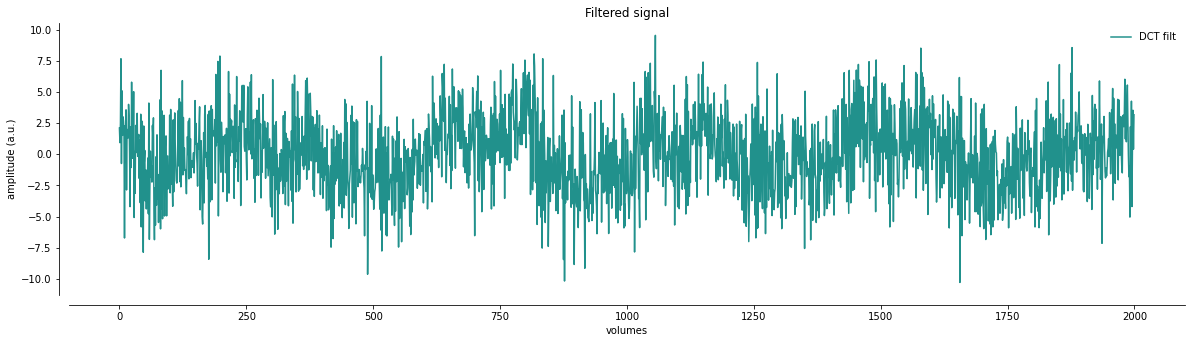

In [78]:
fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 1)
# axs.plot(rolling_median5[f'vox {plot_vox}'].values, color=colors[0], label=f"not detrended")

axs.plot(filt_dct[:,plot_vox], color=colors[0], label=f"DCT filt")
# axs.plot(filt_sg[:,plot_vox], color=colors[0], label=f"Savitsky-Golay")

axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (a.u.)')
axs.set_title("Filtered signal")
axs.legend(frameon=False)
sns.despine(offset=10)

print(raw.shape)

(2000, 720)


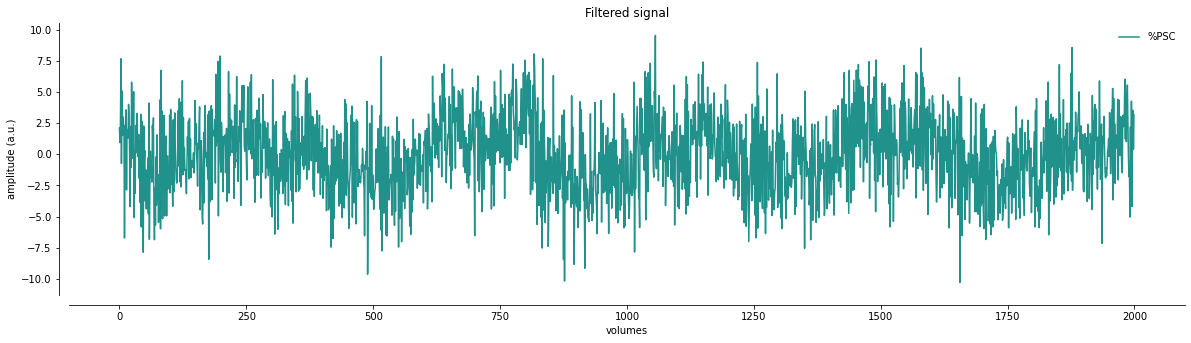

In [67]:
fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 1)
# axs.plot(rolling_median5[f'vox {plot_vox}'].values, color=colors[0], label=f"not detrended")
psc_dct = percent_change(filt_dct, ax=0)
axs.plot(psc_dct[:,plot_vox], color=colors[0], label=f"%PSC")
# axs.plot(filt_sg[:,plot_vox], color=colors[0], label=f"Savitsky-Golay")

axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (a.u.)')
axs.set_title("Filtered signal")
axs.legend(frameon=False)
sns.despine(offset=10)

print(raw.shape)

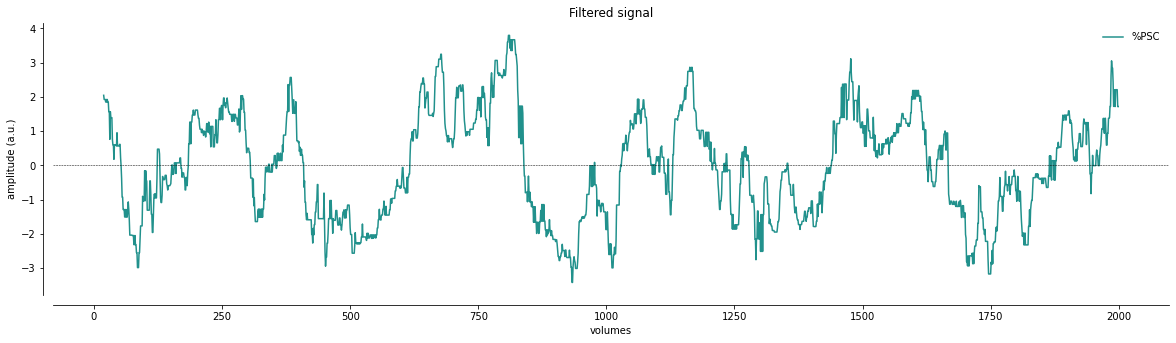

In [72]:
dct_psc_df = pd.DataFrame(psc_dct, index=raw.index, columns=raw.columns)
dct_psc_rol = dct_psc_df.rolling(20, min_periods=None, center=False, win_type=None, on=None, axis=0, closed=None).median()

fig,axs = plt.subplots(figsize=(20,5))
colors = sns.color_palette('viridis', 1)
# axs.plot(rolling_median5[f'vox {plot_vox}'].values, color=colors[0], label=f"not detrended")
axs.plot(dct_psc_rol[f'vox {plot_vox}'].values, color=colors[0], label=f"%PSC")
# axs.plot(filt_sg[:,plot_vox], color=colors[0], label=f"Savitsky-Golay")

axs.set_xlabel('volumes')
axs.set_ylabel('amplitude (a.u.)')
axs.set_title("Filtered signal")
axs.axhline(0, lw=0.5, ls='--', color='k')
axs.legend(frameon=False)
sns.despine(offset=10)

In [79]:
TC3_data = TimeSeries(np.asarray(dct_psc_rol.values), sampling_interval=func.TR)
TC3_spectra = SpectralAnalyzer(TC3_data)
TC3_mtaper = TC3_spectra.spectrum_multi_taper

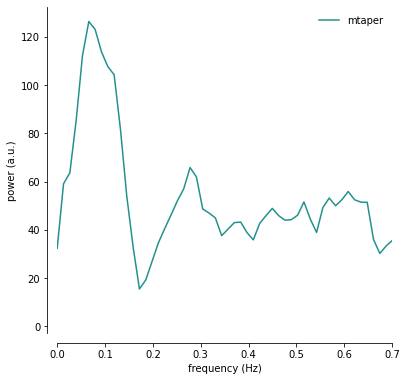

In [80]:
# plot frequency spectra
colors = sns.color_palette('viridis', 1)
fig,axs = plt.subplots(figsize=(6,6))
axs.plot(TC3_mtaper[0], TC3_mtaper[1][359], label='mtaper', color=colors[0])
axs.set_xlim((0,0.7))
axs.set_xlabel('frequency (Hz)')
axs.set_ylabel('power (a.u.)')
axs.legend(frameon=False)
sns.despine(offset=10)